# **Final Assignment Big-data engineering.**

## Pneumonia identification from X-Ray images

#### MSC's Computational Biology, UPM

#### Students: Pablo, Laura, Marta, Paula


# **1) Introduction, description of the dataset, the disease, kaggle challenge...** 

In this work we developed several models capable of cataloging chest X-ray images of patients. The images are classified as pneumonia or normal, depending on whether the image is from a patient with pneumonia or a healthy patient. Obviously the best model will be chosen as a prototype model that could be implemented in a hospital to facilitate the work of doctors and specialists involved in interpreting X-ray images. 

Pneumonia is an infection that affects one or both lungs. It causes the air sacs, or alveoli, in the lungs to fill with fluid or pus.[1]

Most of the time, the body filters germs from the air we breathe in. Sometimes germs such as bacteria, viruses or fungi enter the lungs and cause infections.
When these germs enter the lungs, the immune system, which is the body's natural defense against germs, goes into action. The immune cells attack the germs and can cause inflammation of the air sacs, or alveoli. Inflammation can cause the air sacs to fill with fluid and pus and lead to symptoms of pneumonia. Learn how the lungs work. [2]

Symptoms of pneumonia can be mild or severe. Young children, older adults and people with serious health conditions are at risk of developing more severe pneumonia or life-threatening complications.[3] Symptoms of pneumonia may include:

* chest pain when breathing or coughing
* chills
* cough, with or without mucus
* fever
* low oxygen levels in the blood, measured with a pulse oximeter
* shortness of breath

The risk of pneumonia may be higher due to age, environment, lifestyle and other medical conditions. 

Pneumonia is diagnosed based on your medical history, a physical examination and test results. The most common and quickest tests are: 

A chest x-ray - tests for inflammation in the lungs.
Blood tests: used to find out if your immune system is fighting an infection.
Pulse oximetry: measures the amount of oxygen in the blood. Pneumonia can prevent the lungs from getting enough oxygen into the blood. [4]

As mentioned above, in this paper we are going to analyse the images of one of the most commonly used pneumonia tests, the chest x-ray. A chest x-ray is a quick and painless imaging test to examine structures in and near the chest. This test can help diagnose and evaluate conditions such as pneumonia, heart failure, lung cancer, tuberculosis, sarcoidosis, emphysema and scarring of lung tissue, called fibrosis. Doctors can use chest x-rays to see how well certain treatments are working and to assess the presence of complications after certain procedures or surgeries. [5]

Treatment for pneumonia depends on your risk factors and the severity of the pneumonia. Many people with pneumonia are prescribed medication and recover at home. You may need to be treated in the hospital or in an intensive care unit (ICU) if the pneumonia is severe. [5]


- ## **Image Classification**

Machine learning and deep learning are subfields of artificial intelligence (AI), but they have some key differences. Deep learning is a type of machine learning that uses a more complex architecture and larger amounts of data to learn hierarchical representations of the data. Machine learning models, on the other hand, are simpler and can handle smaller amounts of data, but they require manual feature engineering, whilst deep learning models can extract the features directly from the data.

We decided to use a deep learning approach to classify these images because machine learning models such as RandomForest and KNN are not optimized to analyse this kind of data with such an immense number of features. 

There are multiple types of deep learning models, but we will focus on CNN (Convolutional Neural Network) because CNNs are designed to process grid-like structured data such as images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-2.3.0b20230126-py3-none-manylinux1_x86_64.whl

exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 21.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=2dd8bc0b4b952aea4384750eb2e169d7adb3396840ffc4823ab37fcfd68dee02
  Stored in directory: /root/.cache/pip/wheels/df/88/9e/58ef1f74892fef590330ca0830b5b6d995ba29b44f977b3926
Successfully built pyspark


In [ ]:
! pip install -q kaggle
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

OSError: ignored

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
from zipfile import ZipFile
zf = ZipFile('chest-xray-pneumonia.zip')
zf.extractall('chest-xray-pneumonia')
zf.close()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
import bigdl.dllib.keras.Sequential
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

import matplotlib.pyplot as plt

# spark = SparkSession.builder.appName("ImageDataFrame").getOrCreate()

# df = spark.read.format("image").option("dropInvalid", True).load("/content/chest-xray-pneumonia/chest_xray/train/NORMAL")
# df.select("image.origin", "image.width", "image.height").show(3)

In [ ]:
sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

# **2) Pre-visualization of the dataset**

The dataset has a clear division between train, validation and test sets. Therefore, we will understand that this way is the one that is meant to be used for the analysis.

In [ ]:
# define the path to the different folders:
ntest_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/test/NORMAL/'
ntrain_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/train/NORMAL/'
nvalidation_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/val/NORMAL/'
ptest_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/test/PNEUMONIA/'
ptrain_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/train/PNEUMONIA/'
pvalidation_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/val/PNEUMONIA/'

In [ ]:
import glob

# Picking only the jpeg files (there are some other files starting with "._")
train_normal = glob.glob(ntrain_path + '*jpeg')
train_pneumonia = glob.glob(ptrain_path + '*jpeg')

test_normal = glob.glob(ntest_path + '*jpeg')
test_pneumonia = glob.glob(ptest_path + '*jpeg')

val_normal = glob.glob(nvalidation_path + '*jpeg')
val_pneumonia = glob.glob(pvalidation_path + '*jpeg')

In [ ]:
print("Number of total images for train", len(train_normal)+len(train_pneumonia))
print("Number of Normal patient images:", len(train_normal))
print("Number of Pneumonia patient images:", len(train_pneumonia))

print("")

print("Number of total images for validation", len(val_normal)+len(val_pneumonia))
print("Number of Normal patient images:", len(val_normal))
print("Number of Pneumonia patient images:", len(val_pneumonia))

print("")

print("Number of total images for validation", len(test_normal)+len(test_pneumonia))
print("Number of Normal patient images:", len(test_normal))
print("Number of Pneumonia patient images:", len(test_pneumonia))

At first sight we can see that there's a huge imbalance between the size of the train, test and validation sets, specially for the last one (only 16 images, less than 0.5%). This may lead to some problems on the fit process.

In [ ]:
import random as rn

train_list = []
test_list = []
val_list = []

for x in train_normal:
    train_list.append([x, 0])
    
for x in train_pneumonia:
    train_list.append([x, 1])
    
for x in test_normal:
    test_list.append([x, 0])
    
for x in test_pneumonia:
    test_list.append([x, 1])
    
for x in val_normal:
    val_list.append([x, 0])
    
for x in val_pneumonia:
    val_list.append([x, 1])


#Shuffle in order to avoid having the jpegs organized (as the pneumonia jpegs will be all at first, and then all the normals)
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# Create the dataframes
train_df = spark.createDataFrame(train_list).withColumnRenamed("_1", "image").withColumnRenamed("_2", "Pneumonia")
test_df = spark.createDataFrame(test_list).withColumnRenamed("_1", "image").withColumnRenamed("_2", "Pneumonia")
val_df = spark.createDataFrame(val_list).withColumnRenamed("_1", "image").withColumnRenamed("_2", "Pneumonia")

In [ ]:
train_df.show(5)

+--------------------+---------+
|               image|Pneumonia|
+--------------------+---------+
|/content/drive/My...|        1|
|/content/drive/My...|        0|
|/content/drive/My...|        0|
|/content/drive/My...|        1|
|/content/drive/My...|        1|
+--------------------+---------+
only showing top 5 rows



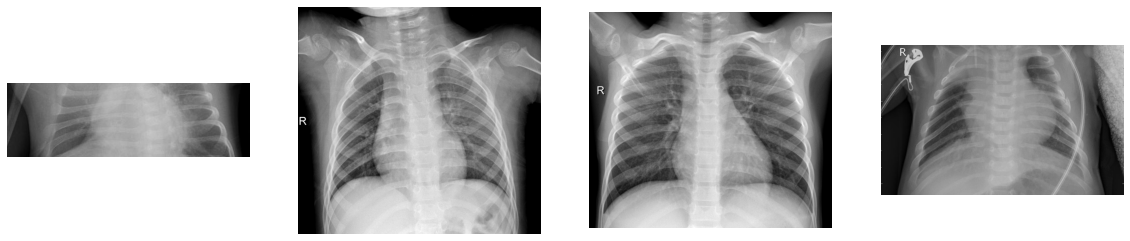

In [ ]:
# Visualizing the images. Here it can be seen that each image has different dimensions, and it needed to be normalised.
plt.figure(figsize=(20,8))



for i in range(4):
  plt.subplot(1,4,i+1)
  plt.axis('off')
  
  img_path = train_df.select('image').collect()[i][0]
  img = plt.imread(img_path)
  plt.imshow(img, cmap='gray')

Just by looking at some of the photos it is seen that the pictures do not have the same size. Therefore, a pre-processing pipeline must be done in order to normalize the dataset

# **3) Preprocessing**

Following these steps, we will reshape the images and crop them in order to normalize them. We will use this same process for every model in order to maintain a standardized method so the results are not affected by differences in the data.

In [ ]:
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/NORMAL"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/PNEUMONIA"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/NORMAL"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/PNEUMONIA"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/NORMAL"
! mkdir "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/PNEUMONIA"

In [ ]:
import os
import cv2
import numpy as np

def resize_image(img_path, target_width, target_height):
    image = cv2.imread(img_path)
    resized = cv2.resize(image, (target_width, target_height),
                        interpolation=cv2.INTER_AREA)
    return resized

def resize_images(img_dir, target_dir, target_width, target_height):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, file)
        resized = resize_image(img_path, target_width, target_height)
        target_path = os.path.join(target_dir, file)
        cv2.imwrite(target_path, resized)



# Resize the train/normal images
target_normal_dir = "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/NORMAL/"
resize_images(ntrain_path, target_normal_dir, 300, 350)

# Resize the train/virus images
target_pneu_dir = "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/PNEUMONIA/"
resize_images(ptrain_path, target_pneu_dir, 300, 350)

# Resize the validation/normal images
target_normal_v_dir = "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/NORMAL/"
resize_images(nvalidation_path, target_normal_v_dir, 300, 350)

# Resize the validation/pneu images
target_pneu_v_dir = "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/PNEUMONIA/"
resize_images(pvalidation_path, target_pneu_v_dir, 300, 350)

# Resize the test/normal images
target_normal_t_dir = "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/NORMAL/"
resize_images(ntest_path, target_normal_t_dir, 300, 350)

# Resize the test/pneu images
target_pneu_t_dir = "/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/PNEUMONIA/"
resize_images(ptest_path, target_pneu_t_dir, 300, 350)

In [ ]:
# define the path to the different folders:
ntest_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/NORMAL/'
ntrain_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/NORMAL/'
nvalidation_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/NORMAL/'
ptest_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/PNEUMONIA/'
ptrain_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/PNEUMONIA/'
pvalidation_path = '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/PNEUMONIA/'

In [ ]:
# Picking only the jpeg files (there are some other files starting with "._")
train_normal = glob.glob(ntrain_path + '*jpeg')
train_pneumonia = glob.glob(ptrain_path + '*jpeg')

test_normal = glob.glob(ntest_path + '*jpeg')
test_pneumonia = glob.glob(ptest_path + '*jpeg')

val_normal = glob.glob(nvalidation_path + '*jpeg')
val_pneumonia = glob.glob(pvalidation_path + '*jpeg')


train_list = []
test_list = []
val_list = []

for x in train_normal:
    train_list.append([x, 0])
    
for x in train_pneumonia:
    train_list.append([x, 1])
    
for x in test_normal:
    test_list.append([x, 0])
    
for x in test_pneumonia:
    test_list.append([x, 1])
    
for x in val_normal:
    val_list.append([x, 0])
    
for x in val_pneumonia:
    val_list.append([x, 1])


#Shuffle in order to avoid having the jpegs organized (as the pneumonia jpegs will be all at first, and then all the normals)
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# Create the dataframes
train_df = spark.createDataFrame(train_list).withColumnRenamed("_1", "image").withColumnRenamed("_2", "Pneumonia")
test_df = spark.createDataFrame(test_list).withColumnRenamed("_1", "image").withColumnRenamed("_2", "Pneumonia")
val_df = spark.createDataFrame(val_list).withColumnRenamed("_1", "image").withColumnRenamed("_2", "Pneumonia")

After reshaping...

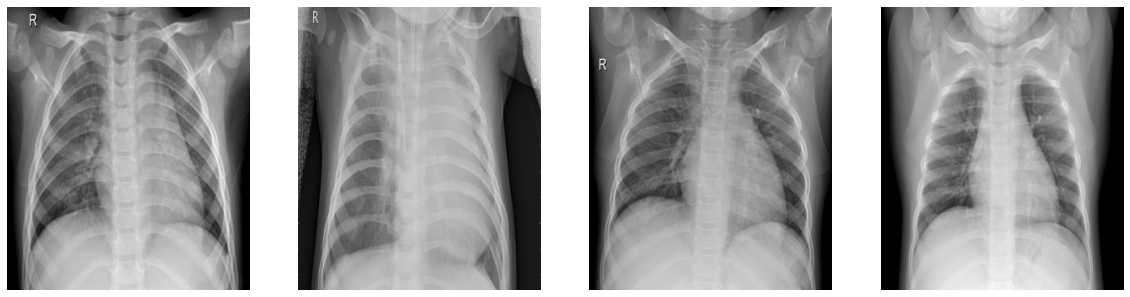

In [ ]:
# Visualizing the images. Here it can be seen that each image has different dimensions, and it needed to be normalised.
plt.figure(figsize=(20,8))

for i in range(4):
  plt.subplot(1,4,i+1)
  plt.axis('off')
  
  img_path = train_df.select('image').collect()[i][0]
  img = plt.imread(img_path)
  plt.imshow(img, cmap='gray')


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 64
# augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_train/',  # this is the target directory
        target_size=(300, 350),  # all images will be resized to 300x350
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_test/',  # this is the target directory
        target_size=(300, 350),  # all images will be resized to 300x350
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

valid_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# generator for validation data
validation_generator = valid_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/FINAL/Resized_val/',
        target_size=(300, 350),
        batch_size=batch_size,
        class_mode='binary')

Found 5229 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **4) CNN MODEL**

A Convolutional Neural Network (CNN) is a type of artificial neural network commonly used for image classification, object detection, and image recognition tasks. It is designed to process and analyze grid-like structured data such as an image, by applying multiple filters to extract features, and then using those features for classification or regression [1]. A typical model includes these kind o layers:

- Convolutional Layer: This layer applies multiple filters to the input data to extract features, producing a feature map.
- Pooling Layer: This layer down-samples the feature map, reducing its size and preserving the most important features.
- ReLU Layer: This layer applies the ReLU activation function to introduce non-linearity to the network, allowing it to learn more complex representations.

These layers can be repeated multiple times in a CNN, creating deeper and more complex models. Some architectures may also include additional layers such as dropout or batch normalization layers to prevent overfitting and improve the performance of the model.

In this case, we will build the model from scratch. Since we lack the necessary skills to build a complex CNN model, we will just rely on a simple model with not so many layers, and without very much hyperparameter tuning, as it's a craft on itself that we still do not master.

Note: Fitting the model with the kaggle data takes around 4h.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import Recall, Precision, AUC
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#Create a convolutional neural network model

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (2, 2), input_shape=(300, 350,3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(32, (2, 2)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (2, 2)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())  # converts 3D feature maps to 1D feature vectors
cnn_model.add(Dense(64))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1))
cnn_model.add(Activation('sigmoid'))

# We want to minimize the false negatives as it's a health issue. Therefore we use f1-score
# Reference: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Once the model is created, config the model with losses and metrics with model.compile()



cnn_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy', 
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.AUC(),
                       get_f1])

In [ ]:
# Fits the model on data yielded batch-by-batch by a Python generator.
cnn_history = cnn_model.fit(train_generator, steps_per_epoch=1000 // batch_size,epochs=100,validation_data=validation_generator,validation_steps=100 // batch_size)

#If batch size is bigger than max number of your validation data set,
# you cannot compute stats. Lower batch size or increase validation_steps.

#saving results
cnn_model.save('/content/drive/MyDrive/pneumo_model.h5')

np.save('/content/drive/MyDrive/pneumo_history.npy',cnn_history.history)

# with open('/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

Epoch 1/100
15/15 [==============================] - 123s 8s/step - loss: 0.9528 - accuracy: 0.7021 - precision_2: 0.7544 - recall_2: 0.8912 - auc_2: 0.4966 - get_f1: 0.7864 - val_loss: 0.8656 - val_accuracy: 0.5000 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.7578 - val_get_f1: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 122s 8s/step - loss: 0.6160 - accuracy: 0.6885 - precision_2: 0.7516 - recall_2: 0.8575 - auc_2: 0.6364 - get_f1: 0.7682 - val_loss: 0.9805 - val_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 1.0000 - val_auc_2: 0.7500 - val_get_f1: 0.6667
Epoch 3/100
15/15 [==============================] - 125s 8s/step - loss: 0.4290 - accuracy: 0.7948 - precision_2: 0.8106 - recall_2: 0.9438 - auc_2: 0.8370 - get_f1: 0.8720 - val_loss: 1.3653 - val_accuracy: 0.5625 - val_precision_2: 0.5333 - val_recall_2: 1.0000 - val_auc_2: 0.6875 - val_get_f1: 0.6957
Epoch 4/100
15/15 [==============================] - 124s 8s/step - lo

In [ ]:
import numpy as np
cnn_history=np.load('/content/drive/MyDrive/pneumo_history.npy',allow_pickle='TRUE').item()

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'auc_2', 'get_f1', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'val_auc_2', 'val_get_f1'])

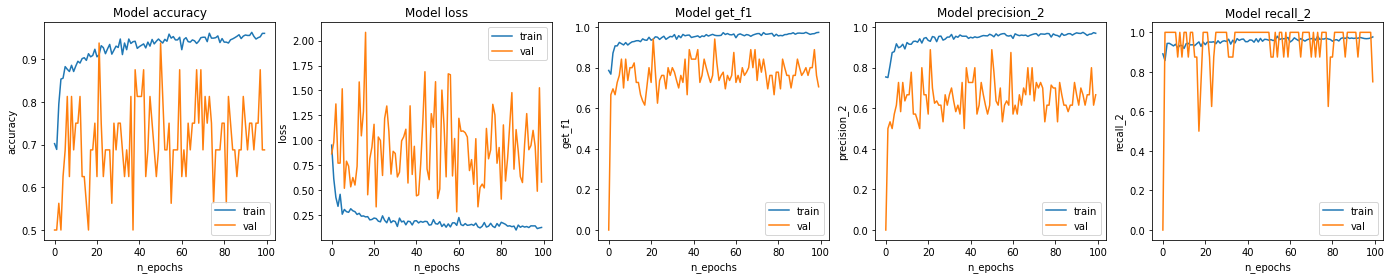

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(24, 4))
ax = ax.ravel()

for n, stat in enumerate(['accuracy', 'loss', "get_f1", 'precision_2',"recall_2"]):
    ax[n].plot(history[stat])
    exec(f"ax[n].plot(history['{'val_'+stat}'])")
    ax[n].set_title('Model {}'.format(stat))
    ax[n].set_xlabel('n_epochs')
    ax[n].set_ylabel(stat)
    ax[n].legend(['train', 'val'])

Looking at these results, we can highlight the large number of ephocs that this model requires to stabilize the accuracy and loss values... this is not good. It is true that both the precision and f1 stabilize faster but even so we will look for better models with less waste of time and RAM. 

# **5) RESNet50 Model**

ResNet stands for Residual Network. It is an innovative neural network that created by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun and appears in the 2015 research paper titled ‘Deep Residual Learning for Image Recognition’. [6]

Because of the framework that ResNets presented it was made possible to train ultra deep neural networks. ResNet has many variants that run on the same concept but have different numbers of layers. Resnet50 is used to denote the variant that can work with 50 neural network layers. [8]

The ResNets were initially applied to the image recognition task but as it is mentioned in the paper that the framework can also be used for non computer vision tasks also to achieve better accuracy. [7]

Moreover, Keras comes with several pre-trained models, making the clasification relatively simple. [8]


In [ ]:
import tensorflow
import keras.backend as K

resnet_model = tensorflow.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (300,350,3)
)

for layer in resnet_model.layers:
  layer.trainable=False

x = resnet_model.output
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tensorflow.keras.layers.Dense(1,activation='sigmoid')(x)

res_model = tensorflow.keras.Model(inputs=resnet_model.input, outputs=predictions)

sgd = tensorflow.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

# As we want to minimize the false negatives (as it's a health issue), we use f1

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val



# Compiling the model
res_model.compile(loss='binary_crossentropy', optimizer= sgd ,metrics=['accuracy', 
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.AUC(),
                       get_f1])


Ussing *summary()* function we can see in-depth information for each layer of the model.

In [ ]:
res_model.summary()

In [ ]:
callback_pt = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=2, factor=.5, min_lr=.00001)

# Fits the model on data
history = res_model.fit(train_generator,epochs=50, 
                    validation_data=validation_generator,
                    steps_per_epoch=10,
                    batch_size=64,
                    callbacks=[callback_pt]
)

#If batch size is bigger than max number of your validation data set,
# you cannot compute stats. Lower batch size or increase validation_steps.

#saving results
res_model.save('/content/drive/MyDrive/Colab Notebooks/FINAL/RESNET2_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/FINAL/RESNET2_history.npy',history.history)


Epoch 1/50
10/10 [==============================] - 306s 30s/step - loss: 0.5647 - accuracy: 0.7762 - precision: 0.8159 - recall: 0.9054 - auc: 0.7021 - get_f1: 0.8022 - val_loss: 0.6156 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - val_auc: 0.9062 - val_get_f1: 0.6957 - lr: 0.0100
Epoch 2/50
10/10 [==============================] - 288s 28s/step - loss: 0.2732 - accuracy: 0.8984 - precision: 0.9158 - recall: 0.9521 - auc: 0.9429 - get_f1: 0.9334 - val_loss: 0.8095 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000 - val_auc: 0.8750 - val_get_f1: 0.7273 - lr: 0.0100
Epoch 3/50
10/10 [==============================] - 288s 28s/step - loss: 0.2101 - accuracy: 0.9187 - precision: 0.9277 - recall: 0.9635 - auc: 0.9657 - get_f1: 0.9437 - val_loss: 0.5606 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_auc: 0.9375 - val_get_f1: 0.8000 - lr: 0.0100
Epoch 4/50
10/10 [==============================] - 281s 27s/step - loss: 0.219

In [ ]:
import numpy as np
history = np.load('/content/drive/MyDrive/Colab Notebooks/FINAL/RESNET2_history.npy',allow_pickle='TRUE').item()

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'get_f1', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_get_f1', 'lr'])

### Plotting the results of the fit process

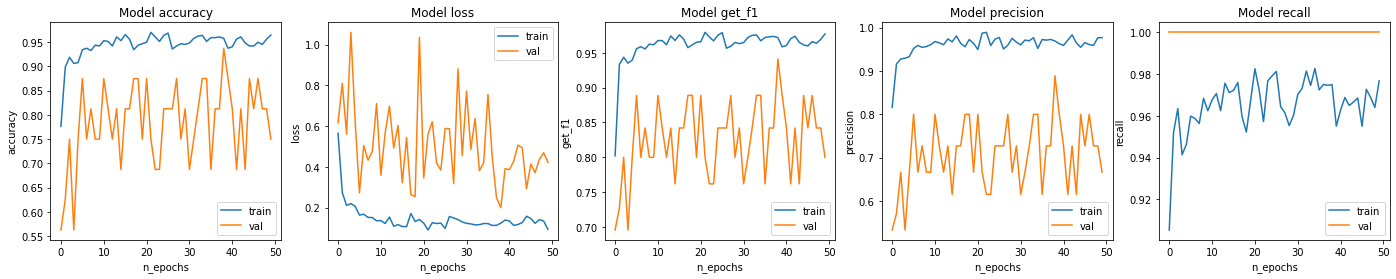

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(24, 4))
ax = ax.ravel()

for n, stat in enumerate(['accuracy', 'loss', "get_f1", 'precision',"recall"]):
    ax[n].plot(history[stat])
    exec(f"ax[n].plot(history['{'val_'+stat}'])")
    ax[n].set_title('Model {}'.format(stat))
    ax[n].set_xlabel('n_epochs')
    ax[n].set_ylabel(stat)
    ax[n].legend(['train', 'val'])

### We could also start with a previously built model from another session.

In [ ]:
from google.colab import files
#files.upload() #upload built_model
history=np.load('/content/drive/MyDrive/Colab Notebooks/FINAL/RESNET2_history.npy',allow_pickle='TRUE').item()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model_name = "/content/drive/MyDrive/Colab Notebooks/FINAL/RESNET2_model.h5"

built_model = keras.models.load_model(model_name, custom_objects={"get_f1": get_f1})

In [ ]:
import keras.backend as K

In [ ]:
#testing the accuracy of the model in the test set
result = built_model.evaluate(test_generator, batch_size=64, steps=100)
print("The f1-score of the model in the test data is: ", result[5])
print("Loss value: ", result[0])

 10/100 [==>...........................] - ETA: 37:27 - loss: 0.3724 - accuracy: 0.8413 - precision: 0.8038 - recall: 0.9872 - auc: 0.9619 - get_f1: 0.8856

100/100 [==============================] - 254s 2s/step - loss: 0.3724 - accuracy: 0.8413 - precision: 0.8038 - recall: 0.9872 - auc: 0.9619 - get_f1: 0.8856
The f1-score of the model in the test data is:  0.8855963945388794
Loss value:  0.37244269251823425


In this case, 50 epochs have been run and thanks to this it has been possible to see that the model manages to achieve good values ​​of both accuracy and precision as well as f1. It is true that the validation set is more dispersed but it is probably due to the number of images processed and their homogeneity.

# **6) INCEPTIONV3**

Description about transfer learning:

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

So, the basic premise of transfer learning is to take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction. The idea is the convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image such as eyes or wheels.


InceptionV3 model: source and description

Inception-v3 is a convolutional neural network architecture from the Inception family that makes several improvements including using Label Smoothing, Factorized 7 x 7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network (along with the use of batch normalization for layers in the sidehead).

Reference: https://franckepeixoto.medium.com/inceptionv3-transfer-learning-conceito-b%C3%A1sico-na-pr%C3%A1tica-381cb5fe9efe

In [ ]:
from keras.applications import InceptionV3

inception_v3_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(300,350,3))

In [ ]:
# add a global spatial average pooling layer

for layer in inception_v3_model.layers:
  layer.trainable = False

x = keras.layers.Flatten()(inception_v3_model.output)
# let's add a fully-connected layer
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
# and a logistic layer -- let's say we have 200 classes
x = keras.layers.Dense(1, activation='sigmoid')(x)

v3model = keras.models.Model(inception_v3_model.input, x)



In [ ]:
rmsp = keras.optimizers.RMSprop(lr=0.0005, decay = 1e-6,momentum = 0.9)

v3model.compile(loss='binary_crossentropy', optimizer= rmsp ,metrics=['accuracy', 
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.AUC(),
                       get_f1])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
v3model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 174, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 174, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


history = v3model.fit(train_generator, epochs=20, 
                  steps_per_epoch=10,
                  batch_size=64,
                  validation_data=validation_generator,
                  callbacks=[callback_es]
)  

#If batch size is bigger than max number of your validation data set,
# you cannot compute stats. Lower batch size or increase validation_steps.

#saving results
v3model.save('/content/drive/MyDrive/Colab Notebooks/FINAL/V3_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/FINAL/V3_history.npy',history.history)


Epoch 1/20
10/10 [==============================] - 230s 23s/step - loss: 2.5766 - accuracy: 0.9234 - precision_1: 0.9485 - recall_1: 0.9465 - auc_1: 0.9186 - get_f1: 0.9467 - val_loss: 4.7171 - val_accuracy: 0.7500 - val_precision_1: 0.6667 - val_recall_1: 1.0000 - val_auc_1: 0.8125 - val_get_f1: 0.8000
Epoch 2/20
10/10 [==============================] - 217s 20s/step - loss: 1.3153 - accuracy: 0.9312 - precision_1: 0.9512 - recall_1: 0.9552 - auc_1: 0.9280 - get_f1: 0.9533 - val_loss: 1.1321 - val_accuracy: 0.9375 - val_precision_1: 0.8889 - val_recall_1: 1.0000 - val_auc_1: 0.9375 - val_get_f1: 0.9412
Epoch 3/20
10/10 [==============================] - 199s 19s/step - loss: 0.6935 - accuracy: 0.9324 - precision_1: 0.9593 - recall_1: 0.9512 - auc_1: 0.9554 - get_f1: 0.9544 - val_loss: 1.3035 - val_accuracy: 0.8125 - val_precision_1: 0.7273 - val_recall_1: 1.0000 - val_auc_1: 0.9375 - val_get_f1: 0.8421
Epoch 4/20
10/10 [==============================] - 198s 19s/step - loss: 0.2335 -

¡¡Problema: sobrepasa RAM permitida y se desconecta del enviroment!! Solo se hacen 10 epochs

In [ ]:
import numpy as np
history = np.load('/content/drive/MyDrive/Colab Notebooks/FINAL/V3_history.npy',allow_pickle='TRUE').item()

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'get_f1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1', 'val_get_f1'])

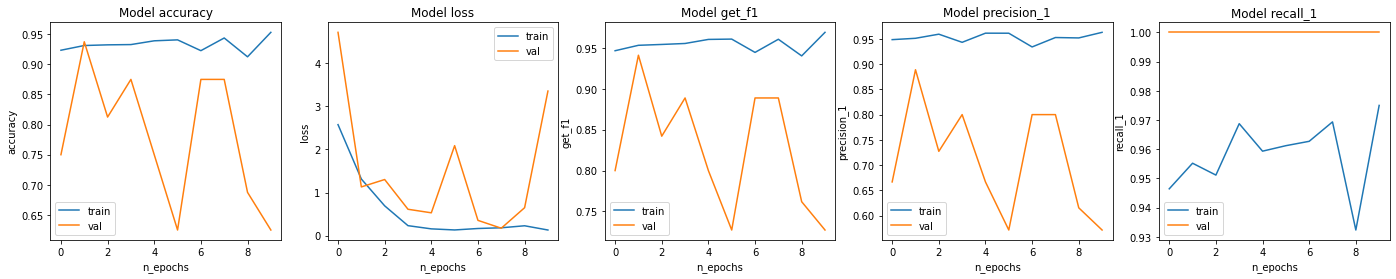

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(24, 4))
ax = ax.ravel()

for n, stat in enumerate(['accuracy', 'loss', "get_f1", 'precision_1',"recall_1"]):
    ax[n].plot(history[stat])
    exec(f"ax[n].plot(history['{'val_'+stat}'])")
    ax[n].set_title('Model {}'.format(stat))
    ax[n].set_xlabel('n_epochs')
    ax[n].set_ylabel(stat)
    ax[n].legend(['train', 'val'])

In [ ]:
history=np.load('/content/drive/MyDrive/Colab Notebooks/FINAL/V3_history.npy',allow_pickle='TRUE').item()

In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model_name = "/content/drive/MyDrive/Colab Notebooks/FINAL/V3_model.h5"

built_model = keras.models.load_model(model_name, custom_objects={"get_f1": get_f1})

In [ ]:
import keras.backend as K

#testing the accuracy of the model in the test set
result = built_model.evaluate(test_generator, batch_size=64, steps=100)
print("The f1-score of the model in the test data is: ", result[5])
print("Loss value: ", result[0])

 10/100 [==>...........................] - ETA: 25:30 - loss: 0.6058 - accuracy: 0.8702 - precision_1: 0.8552 - recall_1: 0.9538 - auc_1: 0.9306 - get_f1: 0.9016

100/100 [==============================] - 174s 2s/step - loss: 0.6058 - accuracy: 0.8702 - precision_1: 0.8552 - recall_1: 0.9538 - auc_1: 0.9306 - get_f1: 0.9016
The f1-score of the model in the test data is:  0.9015622138977051
Loss value:  0.6057860851287842


It was only possible to do 10 epochs because it consumes a lot of RAM, but it can be appreciated both the precision and the precision that is maintained throughout the epochs in the train set. It can be also appreciated the great loss that occurs as soon as the epcochs begin, in the second it makes a great drop, both in the train and in the val, that shows a good prediction. 

# **7) VGG16**

As in the previous models, Keras VGG16 is a deep learning model. This model is typically used in prediction, fine tuning and feature extraction models. The difference from other models is because this model focuses on convolution layers following the arrangement of the maximum layers of the group and the convolution was consistent throughout the architecture [1].  

In addition, this model usually uses 224x224 photo dimensions, so the images are resized compared to previous models. The code used to realise the Keras VGG16 model can be found at the following link: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/drive/MyDrive/BigData/Resized/train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/drive/MyDrive/BigData/Resized/test", target_size=(224,224))
vadata = ImageDataGenerator()
validationdata = vadata.flow_from_directory(directory="/content/drive/MyDrive/BigData/Resized/validation", target_size=(224,224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [ ]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
batch_size=64
steps_per_epoch = len(traindata)//batch_size
validation_steps = len(validationdata)//batch_size

hist = model.fit(traindata, steps_per_epoch= steps_per_epoch, validation_data= validationdata, validation_steps= validation_steps, epochs=10)

Epoch 1/10
2/2 [==============================] - 163s 85s/step - loss: 16870.8984 - accuracy: 0.4531
Epoch 2/10
2/2 [==============================] - 140s 70s/step - loss: 0.9071 - accuracy: 0.3594
Epoch 3/10
2/2 [==============================] - 130s 64s/step - loss: 0.6537 - accuracy: 0.7812
Epoch 4/10
2/2 [==============================] - 133s 66s/step - loss: 1.1465 - accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 132s 66s/step - loss: 0.6667 - accuracy: 0.6562
Epoch 6/10
2/2 [==============================] - 133s 65s/step - loss: 0.6400 - accuracy: 0.7188
Epoch 7/10
2/2 [==============================] - 133s 67s/step - loss: 5.7530 - accuracy: 0.5156
Epoch 8/10
2/2 [==============================] - 134s 65s/step - loss: 0.6690 - accuracy: 0.6562
Epoch 9/10
2/2 [==============================] - 133s 68s/step - loss: 0.5783 - accuracy: 0.8281
Epoch 10/10
2/2 [==============================] - 131s 64s/step - loss: 0.6051 - accuracy: 0.7656


In this case, we only evaluate the values of "loss" and "accuracy" as we can see, with respect to other models we get much lower acccuracys when we use the training and validation data. In addition, the model, even though it has only 10 epochs and two steps per epoch, takes a long time, approximately 30 min.

Text(0.5, 0, 'Epoch')

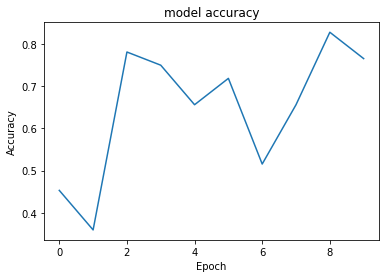

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

In this graph where the accuracy of the model is represented, it is observed that with 10 epochs the model does not stabilise and, as mentioned above, low accuracys are obtained, so it is not a good model for the given data. Therefore, the previous models predict better the disease in the radiographs with respect to VGG16. 

In [ ]:
result = model.evaluate(testdata, batch_size=64, steps=30)

20/30 [===================>..........] - ETA: 2:56 - loss: 0.6795 - accuracy: 0.6250

30/30 [==============================] - 355s 12s/step - loss: 0.6795 - accuracy: 0.6250


After checking how the model performs on the test data we obtain an accuracy of 62.50%, i.e. 37.5% of the data is incorrectly predicted. This percentage is very high, which corroborates that it is not a good model for the given data. 

In [ ]:
model.save('/content/drive/MyDrive/BigData/vgg16_model.h5')
np.save('/content/drive/MyDrive/BigData/vgg16_history.npy',hist.history)

# **10) BigDL implementation**

After many days of trial and error, we couldn't manage to implement BigDL.  

In [ ]:
#This test was done in a different session using bigdl-orca with ray

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import Recall, Precision, AUC
import keras.backend as K
from bigdl.orca.learn.tf2.estimator import Estimator 

# As we want to minimize the false negatives (as it's a health issue), we use f1

est = Estimator.from_keras(model=built_model, backend='bigdl')

# the path of the directory where to save the log files to be parsed by TensorBoard
tensorboard_dir = "/content/runs"
# "bigdl" is the application name for tensorboard to save training and validation results under log path
est.set_tensorboard(tensorboard_dir, "bigdl")


(scheduler +53m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-02-06 17:34:39,008	WARNING worker.py:1245 -- The actor or task with ID ffffffffffffffff6534b4ae5c8f46c526668af501000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 2.000000}
Available resources on this node: {0.000000/2.000000 CPU, 270593040.039062 GiB/270593040.039062 GiB memory, 135296519.970703 GiB/135296519.970703 GiB object_store_memory, 1.000000/1.000000 node:172.28.0.12}
 In total there are 0 pending tasks and 1 pending actors on this node.


(scheduler +53m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +54m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +55m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +55m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +5

KeyboardInterrupt: ignored

Directly copied from the github transfer learning tutorial inside BigDL documentation and tested in a different session, it crashes anyways.

In [ ]:
# train dataset has enough images to test if the NNmodel works
! mkdir "/content/allimg"
! cp -r "/content/chest-xray-pneumonia/chest_xray/train/NORMAL/." "/content/allimg"
! cp -r "/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/." "/content/allimg"

image_path = "/content/allimg"
imageDF = NNImageReader.readImages(image_path, sc, resizeH=350, resizeW=300,
                                       image_codec=3)
getName = udf(lambda row: os.path.basename(row[0]), StringType())
getLabel = udf(lambda name: 2.0 if name.startswith('person') else 1.0, DoubleType())
labelDF = imageDF.withColumn("name", getName(col("image"))).withColumn("label", getLabel(col('name')))
(trainingDF, validationDF) = labelDF.randomSplit([0.9, 0.1])

In [ ]:
from keras.applications import InceptionV3

inception_v3_model = InceptionV3(include_top=False, weights='imagenet',input_shape=(300,350,3))
# compose a pipeline that includes feature transform, pretrained model and Logistic Regression
transformer = ChainedPreprocessing([RowToImageFeature(), ImageResize(300, 350), ImageMatToTensor(), ImageFeatureToTensor()])
preTrainedNNModel = NNModel(inception_v3_model, transformer).setFeaturesCol("image").setPredictionCol("embedding")
lrModel = Sequential().add(Linear(1000, 2)).add(LogSoftMax())
classifier = NNClassifier(lrModel, ClassNLLCriterion(), SeqToTensor([1000]))\
    .setLearningRate(options.learning_rate)\
    .setOptimMethod(Adam())\
    .setBatchSize(options.batch_size)\
    .setMaxEpoch(options.nb_epoch)\
    .setFeaturesCol("embedding")\
    .setCachingSample(False)
pipeline = Pipeline(stages=[preTrainedNNModel, classifier])
catdogModel = pipeline.fit(trainingDF)
predictionDF = catdogModel.transform(validationDF).cache()
predictionDF.sample(False, 0.1).show()

evaluator = MulticlassClassificationEvaluator(
      labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)

creating: createRowToImageFeature
creating: createImageResize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing
creating: createTensorToSample
creating: createChainedPreprocessing
creating: createNNModel


Py4JJavaError: ignored

# **9) Conclusions**

Improving the quality of the provided data would probably greatly improve the model. The train set is around 5000 images while the test set is around 600. In addition, the validation set only consists of 16 images, it does not even reach 0.5% of the total data... In our opinion, another type of partition could be made to be more suitable for the creation and validation of the models, for example, using 70% for training, 20% for validation and 10% for testing, which is the current recomendations for standard modelling. It would also be greatly improved with balanced preliminary data, which is 50% patients with pneumonia and 50% healthy patients.

With the recent advancement of AI, the analysis of medical and scientific images has been an increasingly less difficult process. In this work we have been able to verify that it is possible to generate a good model within what is possible to do so. The difference in focus brought by the different densities of the lungs in the X-ray images is learned by the models and this makes them find out the diagnostic answer. Advances in deep learning algorithms promise greater precision in these types of tasks. Important tasks in the field of medicine that can be very helpful to specialists and doctors.

# **Bibliography**

1. Neumonía - ¿Qué es la neumonía? | NHLBI, NIH. https://www.nhlbi.nih.gov/es/salud/neumonia (2022).
2. Neumonía - Causas y factores de riesgo | NHLBI, NIH. https://www.nhlbi.nih.gov/es/salud/neumonia/causas (2022).
3. Neumonía - Diagnóstico | NHLBI, NIH. https://www.nhlbi.nih.gov/es/salud/neumonia/diagnostico (2022).
4. Neumonía - Síntomas | NHLBI, NIH. https://www.nhlbi.nih.gov/es/salud/neumonia/sintomas (2022).
5. Neumonía - Tratamiento | NHLBI, NIH. https://www.nhlbi.nih.gov/es/salud/neumonia/tratamiento (2022).
6. https://machinelearningmastery.com/transfer-learning-for-deep-learning/
7. Understanding ResNet50 architecture. OpenGenus IQ: Computing Expertise & Legacy https://iq.opengenus.org/resnet50-architecture/ (2020).
8. https://viso.ai/deep-learning/resnet-residual-neural-network/

CNN Model:

1. https://developers.google.com/machine-learning/glossary/?hl=es-419#convolutional_neural_network 

ResNet50:

1. https://www.kaggle.com/code/suniliitb96/tutorial-keras-transfer-learning-with-resnet50


INCEPTIONV3:

1. https://paperswithcode.com/method/inception-v3

2. https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce#:~:text=The%20basic%20premise%20of%20transfer,layers%20which%20make%20a%20prediction.

VGG16:

1. https://www.educba.com/keras-vgg16/

KERAS:

1. https://keras.io/getting_started/intro_to_keras_for_engineers/#data-preprocessing-with-keras 

2. https://www.tensorflow.org/guide/keras/sequential_model?hl=es-419

3. https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=es-419

4. https://www.tensorflow.org/guide/keras/save_and_serialize?hl=es-419

5. https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

6. http://market.itcgb.com/Contents/Intel/OR_AI_BJ/images/Bigdl%20tutorial_final.pdf 